1.  Name:	    Name of the country concerned
2.  Landmass:	1=N.America, 2=S.America, 3=Europe, 4=Africa, 4=Asia, 6=Oceania
3.  Zone:	    Geographic quadrant, based on Greenwich and the Equator: 1=NE, 2=SE, 3=SW, 4=NW
4.  Area:	    in thousands of square km
5.  Population:	in round millions
6.  Language     1=English, 2=Spanish, 3=French, 4=German, 5=Slavic, 6=Other Indo-European, 7=Chinese, 8=Arabic, 9=Japanese/Turkish/Finnish/Magyar, 10=Others
7.  Religion     0=Catholic, 1=Other Christian, 2=Muslim, 3=Buddhist, 4=Hindu, 5=Ethnic, 6=Marxist, 7=Others
8.  Bars         Number of vertical bars in the flag
9.  Stripes      Number of horizontal stripes in the flag
10. Colours      Number of different colours in the flag
11. Red          0 if red absent, 1 if red present in the flag
12. Green        same for green
13. Blue         same for blue
14. Gold         same for gold (also yellow)
15. White        same for white
16. Black        same for black
17. Orange       same for orange (also brown)
18. Mainhue      predominant colour in the flag (tie-breaks decided by taking the topmost hue, if that fails then the most central hue, and if that fails the leftmost hue)
19. Circles      Number of circles in the flag
20. Crosses      Number of (upright) crosses
21. Saltires     Number of diagonal crosses
22. Quarters     Number of quartered sections
23. Sunstars     Number of sun or star symbols
24. Crescent     1 if a crescent moon symbol present, else 0
25. Triangle     1 if any triangles present, 0 otherwise
26. Icon         1 if an inanimate image present (e.g., a boat), otherwise 0
27. Animate      1 if an animate image (e.g., an eagle, a tree, a human hand) present, 0 otherwise
28. Text         1 if any letters or writing on the flag (e.g., a motto or slogan), 0 otherwise
29. Topleft      Colour in the top-left corner (moving right to decide tie-breaks)
30. Botright     Colour in the bottom-left corner (moving left to decide tie-breaks)


In [72]:
import pandas as pd
import numpy as np
flags = pd.read_csv('./flag(1).data', sep=',')
print(flags)

               Name  Landmass  Zone  Area  Population  Language  Religion  \
0       Afghanistan         5     1   648          16        10         2   
1           Albania         3     1    29           3         6         6   
2           Algeria         4     1  2388          20         8         2   
3    American-Samoa         6     3     0           0         1         1   
4           Andorra         3     1     0           0         6         0   
..              ...       ...   ...   ...         ...       ...       ...   
189   Western-Samoa         6     3     3           0         1         1   
190      Yugoslavia         3     1   256          22         6         6   
191           Zaire         4     2   905          28        10         5   
192          Zambia         4     2   753           6        10         5   
193        Zimbabwe         4     2   391           8        10         5   

     Bars  Stripes  Colours  Red  Green  Blue  Gold  White  Black  Orange  

I think Name is an unimportant column so I think we will drop that.

Columns with labels are Landmass, Zone, Language and Religion.  So those need to be encoded.

For classifying output, I think I will do all of the columns with labels...I don't want landmass predicting religion or anything like that...this is simply about flags.

In [73]:
print(flags.columns)

Index(['Name', 'Landmass', 'Zone', 'Area', 'Population', 'Language',
       'Religion', 'Bars', 'Stripes', 'Colours', 'Red', 'Green', 'Blue',
       'Gold', 'White', 'Black', 'Orange', 'Mainhue', 'Circles', 'Crosses',
       'Saltires', 'Quarters', 'Sunstars', 'Crescent', 'Triangle', 'Icon',
       'Animate', 'Text', 'Topleft', 'Botright'],
      dtype='object')


In [74]:
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)

flagsOut = flags.drop('Name', axis = 1)

landmass = pd.get_dummies(flagsOut.Landmass)
language = pd.get_dummies(flagsOut.Language)
religion = pd.get_dummies(flagsOut.Religion)
zone = pd.get_dummies(flagsOut.Zone)

flagsOut = flagsOut.drop('Landmass', axis = 1)
flagsOut = flagsOut.drop('Language', axis = 1)
flagsOut = flagsOut.drop('Religion', axis = 1)
flagsOut = flagsOut.drop('Zone', axis = 1)

x = pd.get_dummies(flagsOut.Topleft, prefix='topleft')
y = pd.get_dummies(flagsOut.Botright, prefix = 'botright')
z = pd.get_dummies(flagsOut.Mainhue, prefix = 'mainhue')

flagsOut = flagsOut.drop('Botright', axis=1)
flagsOut = flagsOut.drop('Topleft', axis=1)
flagsOut = flagsOut.drop('Mainhue', axis=1)

#flagsOut = flagsOut.join(w)
flagsOut = flagsOut.join(x)
flagsOut = flagsOut.join(y)
flagsOut = flagsOut.join(z)

scaler = MinMaxScaler()
flagsScaled = scaler.fit_transform(flagsOut)  #flagsScaled is a numpy array
land = landmass.to_numpy()
lang = language.to_numpy()
rlgn = religion.to_numpy()
zn = zone.to_numpy()

print(land)
print(lang)

[[0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 ...
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]]
[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


# Fun With Flags Episode 1: Can flag metrics predict land mass?
*Hint: They do not

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

model = Sequential()

layers = [
    Dense(20, activation='relu', name='layer1'),
    Dense(10, activation='relu', name='layer2'),
    Dense(6, activation='sigmoid', name='Output')
]

for layer in layers:
    model.add(layer)

model.compile(optimizer=SGD(learning_rate=.01), loss='mse', metrics=['accuracy'])
hist = model.fit(flagsScaled, land, validation_split=.2, epochs=500, verbose=0)

In [76]:
from sklearn.model_selection import train_test_split

flagsTrain, flagsTest, landTrain, landTest = train_test_split(flagsScaled, land, test_size = 0.20, random_state=5)

pred_train= model.predict(flagsTrain)
score, acc = model.evaluate(flagsTrain, landTrain, verbose=0)
print('Training Error: %.3f' % score)
print('Training Accuracy: %.3f' % acc)

Training Error: 0.139
Training Accuracy: 0.206


In [77]:
pred_train= model.predict(flagsTest)
score, acc = model.evaluate(flagsTest, landTest, verbose=0)
print('Test Error: %.3f' % score)
print('Test Accuracy: %.3f' % acc)

Test Error: 0.137
Test Accuracy: 0.205


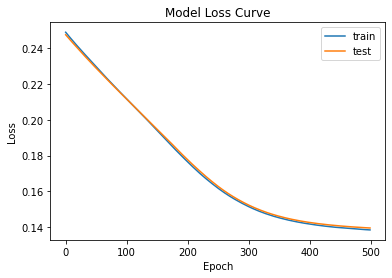

In [78]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

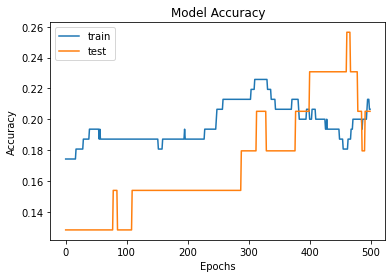

In [79]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [80]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
#from keras.optimizers import Adam

def createmodel(n_layers, first_layer_nodes, second_layer_nodes, learning_rate=.1):
    model = Sequential()
    
    #n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(2):
        if i==1:
            model.add(Dense(first_layer_nodes, activation='relu'))
        else:
            model.add(Dense(second_layer_nodes, activation='relu'))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(6, activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=learning_rate), 
                  loss='mse', metrics = ["accuracy"]) #note: metrics could also be 'mse'
    
    return model

param_grid = dict(n_layers=[2], first_layer_nodes = [20, 10, 5], second_layer_nodes=[20,10,5],
                  epochs = [150, 300, 500], learning_rate= [.01, .15, .3, .5])

model = KerasClassifier(build_fn=createmodel, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(flagsScaled, land)

In [81]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.448638 using {'epochs': 500, 'first_layer_nodes': 20, 'learning_rate': 0.5, 'n_layers': 2, 'second_layer_nodes': 10}
0.180449 (0.008019) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.01, 'n_layers': 2, 'second_layer_nodes': 20}
0.267949 (0.028147) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.01, 'n_layers': 2, 'second_layer_nodes': 10}
0.201282 (0.066197) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.01, 'n_layers': 2, 'second_layer_nodes': 5}
0.335176 (0.077287) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.15, 'n_layers': 2, 'second_layer_nodes': 20}
0.309135 (0.023379) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.15, 'n_layers': 2, 'second_layer_nodes': 10}
0.309455 (0.055792) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.15, 'n_layers': 2, 'second_layer_nodes': 5}
0.376122 (0.029648) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.3, 'n

### Decision Tree

In [82]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

flagsTrain, flagsTest, landTrain, landTest = train_test_split(flagsScaled, land, test_size = 0.20, random_state=5)
tree_model = DecisionTreeClassifier().fit(flagsTrain, landTrain)
tree_pred = tree_model.predict(flagsTest)

In [83]:
print("Accuracy: ", accuracy_score(landTest, tree_pred))
print("Classification Report: \n", classification_report(landTest, tree_pred))
print("Confusion Matrix: \n", confusion_matrix(np.argmax(landTest, axis=1), np.argmax(tree_pred, axis=1)))

Accuracy:  0.46153846153846156
Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.00      0.00      0.00         2
           2       0.60      0.33      0.43         9
           3       0.73      0.73      0.73        11
           4       0.00      0.00      0.00         4
           5       0.17      0.25      0.20         4

   micro avg       0.46      0.46      0.46        39
   macro avg       0.36      0.33      0.34        39
weighted avg       0.51      0.46      0.48        39
 samples avg       0.46      0.46      0.46        39

Confusion Matrix: 
 [[6 1 1 0 1 0]
 [0 0 0 1 0 1]
 [0 2 3 0 2 2]
 [1 0 0 8 1 1]
 [0 1 1 1 0 1]
 [2 0 0 1 0 1]]


# TODO//Do hyper tension to see if we can get better results
As of now, elements of a flag are not a good characterist to see what landmass the flag is from.  Stay tuned for another episode of fun with flags.

# Fun With Flags Episode 2: Can flag metrics predict language?
Probably not lol

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

model = Sequential()

layers = [
    Dense(20, activation='relu', name='layer1'),
    Dense(15, activation='relu', name='layer2'),
    Dense(10, activation='sigmoid', name='Output')
]

for layer in layers:
    model.add(layer)

model.compile(optimizer=SGD(learning_rate=.3), loss='mse', metrics=['accuracy'])
hist = model.fit(flagsScaled, lang, validation_split=.2, epochs=150, verbose=0)

In [85]:
from sklearn.model_selection import train_test_split

flagsTrain, flagsTest, langTrain, langTest = train_test_split(flagsScaled, lang, test_size = 0.20, random_state=5)

pred_train= model.predict(flagsTrain)
score, acc = model.evaluate(flagsTrain, langTrain, verbose=0)
print('Training Error: %.3f' % score)
print('Training Accuracy: %.3f' % acc)

Training Error: 0.082
Training Accuracy: 0.310


In [86]:
pred_train= model.predict(flagsTest)
score, acc = model.evaluate(flagsTest, langTest, verbose=0)
print('Test Error: %.3f' % score)
print('Test Accuracy: %.3f' % acc)

Test Error: 0.077
Test Accuracy: 0.436


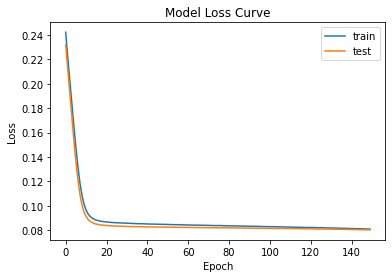

In [87]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

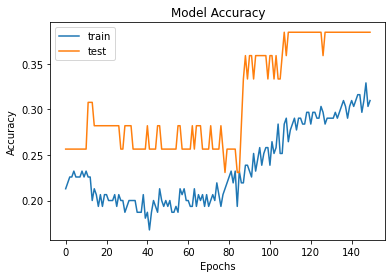

In [88]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [89]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
#from keras.optimizers import Adam

def createmodel(n_layers, first_layer_nodes, second_layer_nodes, learning_rate=.1):
    model = Sequential()
    
    #n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(2):
        if i==1:
            model.add(Dense(first_layer_nodes, activation='relu'))
        else:
            model.add(Dense(second_layer_nodes, activation='relu'))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(10, activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=learning_rate), 
                  loss='mse', metrics = ["accuracy"]) #note: metrics could also be 'mse'
    
    return model

param_grid = dict(n_layers=[2], first_layer_nodes = [20, 10, 5], second_layer_nodes=[20,10,5],
                  epochs = [150, 300, 500], learning_rate= [.01, .15, .3, .5])

model = KerasClassifier(build_fn=createmodel, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(flagsScaled, lang)

In [90]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.314423 using {'epochs': 300, 'first_layer_nodes': 20, 'learning_rate': 0.3, 'n_layers': 2, 'second_layer_nodes': 20}
0.170433 (0.098874) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.01, 'n_layers': 2, 'second_layer_nodes': 20}
0.236619 (0.070444) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.01, 'n_layers': 2, 'second_layer_nodes': 10}
0.175160 (0.013372) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.01, 'n_layers': 2, 'second_layer_nodes': 5}
0.221554 (0.018100) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.15, 'n_layers': 2, 'second_layer_nodes': 20}
0.216747 (0.046698) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.15, 'n_layers': 2, 'second_layer_nodes': 10}
0.273157 (0.025681) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.15, 'n_layers': 2, 'second_layer_nodes': 5}
0.242147 (0.035495) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.3, 'n

### Decision Tree

In [91]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

flagsTrain, flagsTest, langTrain, langTest = train_test_split(flagsScaled, lang, test_size = 0.20, random_state=5)
tree_model = DecisionTreeClassifier().fit(flagsTrain, langTrain)
tree_pred = tree_model.predict(flagsTest)

In [92]:
print("Accuracy: ", accuracy_score(langTest, tree_pred))
print("Classification Report: \n", classification_report(langTest, tree_pred))
print("Confusion Matrix: \n", confusion_matrix(np.argmax(langTest, axis=1), np.argmax(tree_pred, axis=1)))

Accuracy:  0.46153846153846156
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.17      0.25      0.20         4
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.20      0.17      0.18         6
           6       0.00      0.00      0.00         0
           7       1.00      0.50      0.67         2
           8       0.00      0.00      0.00         0
           9       0.50      0.56      0.53         9

   micro avg       0.46      0.46      0.46        39
   macro avg       0.26      0.23      0.24        39
weighted avg       0.45      0.46      0.45        39
 samples avg       0.46      0.46      0.46        39

Confusion Matrix: 
 [[10  0  0  0  0  1  0  1]
 [ 1  1  1  0  0  0  0  1]
 [ 1  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  1  0  0]
 [ 

c:\users\socce\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\socce\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Fun With Flags episode 3: Religion

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

model = Sequential()

layers = [
    Dense(20, activation='relu', name='layer1'),
    Dense(15, activation='relu', name='layer2'),
    Dense(8, activation='sigmoid', name='Output')
]

for layer in layers:
    model.add(layer)

model.compile(optimizer=SGD(learning_rate=.3), loss='mse', metrics=['accuracy'])
hist = model.fit(flagsScaled, rlgn, validation_split=.2, epochs=50, verbose=0)

In [94]:
from sklearn.model_selection import train_test_split

flagsTrain, flagsTest, rlgnTrain, rlgnTest = train_test_split(flagsScaled, rlgn, test_size = 0.20, random_state=5)

pred_train= model.predict(flagsTrain)
score, acc = model.evaluate(flagsTrain, rlgnTrain, verbose=0)
print('Training Error: %.3f' % score)
print('Training Accuracy: %.3f' % acc)

Training Error: 0.095
Training Accuracy: 0.381


In [95]:
pred_train= model.predict(flagsTest)
score, acc = model.evaluate(flagsTest, rlgnTest, verbose=0)
print('Test Error: %.3f' % score)
print('Test Accuracy: %.3f' % acc)

Test Error: 0.095
Test Accuracy: 0.333


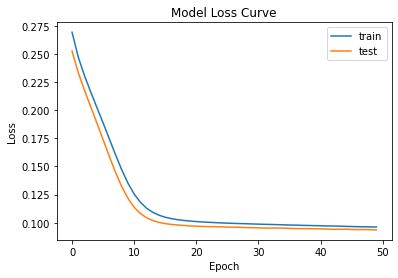

In [96]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

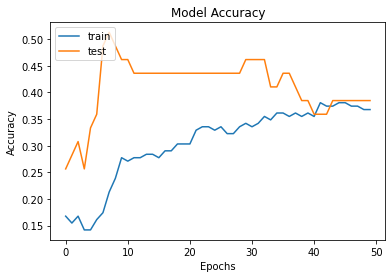

In [97]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [98]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
#from keras.optimizers import Adam

def createmodel(n_layers, first_layer_nodes, second_layer_nodes, learning_rate=.1):
    model = Sequential()
    
    #n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(2):
        if i==1:
            model.add(Dense(first_layer_nodes, activation='relu'))
        else:
            model.add(Dense(second_layer_nodes, activation='relu'))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(8, activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=learning_rate), 
                  loss='mse', metrics = ["accuracy"]) #note: metrics could also be 'mse'
    
    return model

param_grid = dict(n_layers=[2], first_layer_nodes = [20, 10, 5], second_layer_nodes=[20,10,5],
                  epochs = [150, 300, 500], learning_rate= [.01, .15, .3, .5])

model = KerasClassifier(build_fn=createmodel, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(flagsScaled, rlgn)

In [99]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.443029 using {'epochs': 300, 'first_layer_nodes': 10, 'learning_rate': 0.3, 'n_layers': 2, 'second_layer_nodes': 10}
0.222115 (0.077573) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.01, 'n_layers': 2, 'second_layer_nodes': 20}
0.283654 (0.037447) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.01, 'n_layers': 2, 'second_layer_nodes': 10}
0.154407 (0.099447) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.01, 'n_layers': 2, 'second_layer_nodes': 5}
0.329968 (0.015899) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.15, 'n_layers': 2, 'second_layer_nodes': 20}
0.350962 (0.062468) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.15, 'n_layers': 2, 'second_layer_nodes': 10}
0.324760 (0.037760) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.15, 'n_layers': 2, 'second_layer_nodes': 5}
0.361058 (0.034336) with: {'epochs': 150, 'first_layer_nodes': 20, 'learning_rate': 0.3, 'n

### Decision Trees

In [116]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

flagsTrain, flagsTest, rlgnTrain, rlgnTest = train_test_split(flagsScaled, rlgn, test_size = 0.20, random_state=5)
tree_model = DecisionTreeClassifier().fit(flagsTrain, rlgnTrain)
tree_pred = tree_model.predict(flagsTest)


In [121]:
from sklearn.preprocessing import MultiLabelBinarizer

print("Accuracy: ", accuracy_score(rlgnTest, tree_pred))
print("Classification Report: \n", classification_report(rlgnTest, tree_pred))
print("Confusion Matrix: \n", confusion_matrix(np.argmax(rlgnTest, axis=1), np.argmax(tree_pred, axis=1)))

Accuracy:  0.358974358974359
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.67      0.92      0.77        13
           2       0.17      0.50      0.25         4
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         0

   micro avg       0.36      0.36      0.36        39
   macro avg       0.10      0.18      0.13        39
weighted avg       0.24      0.36      0.28        39
 samples avg       0.36      0.36      0.36        39

Confusion Matrix: 
 [[ 0  4  4  0  0  0  1  0]
 [ 0 12  1  0  0  0  0  0]
 [ 0  1  2  0  0  1  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 3  0  2  0  0  0  0  1]
 [ 2  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


c:\users\socce\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\socce\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
